# GenomicSuperSignature in Human trisome project


Marc Subirana-Granés (2024)

Description


# Load libraries/modules


In [85]:
library(GenomicSuperSignature)
library(here)
library(dplyr)
library(tidyverse)
library(factoextra)
# load plier utils
source(here::here("scripts/plier_util.R"))


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



# Load data


In [32]:
# Define output nb path
output_nb_path <- here("output/nbs/compare_same_model_PLIER_DelayedPLIER")

# Create directory if it doesn't exist
if (!dir.exists(output_nb_path)) {
  dir.create(output_nb_path, recursive = TRUE)
}

# load # GSE190125 RNA-seq data
counts_matrix <- here::here("data/GSE190125/GSE190125_Counts_for_GEO.txt")
raw_gene_counts_GSE190125 <- read.table(counts_matrix, header = TRUE, sep = "\t", check.names = FALSE)
gene_counts_GSE190125 <- raw_gene_counts_GSE190125 %>%
  dplyr::select(-chr, -gene_type) %>%
  pivot_wider(
    names_from = SampleID,
    values_from = raw_count,
    values_fill = list(raw_count = 0)
  ) %>%
  dplyr::select(Geneid = EnsemblID, GeneSymbol = gene_name, everything())

head(gene_counts_GSE190125)


Geneid,GeneSymbol,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000121410.12,A1BG,25,19,13,7,28,17,23,21,⋯,6,13,7,10,28,22,18,30,10,23
ENSG00000268895.6,A1BG-AS1,378,305,275,124,240,176,469,229,⋯,363,447,225,261,391,308,226,292,253,314
ENSG00000148584.15,A1CF,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000175899.14,A2M,6,11,4,11,16,4,39,11,⋯,9,15,12,18,4,7,18,8,1,12
ENSG00000245105.4,A2M-AS1,64,77,47,113,51,55,133,64,⋯,41,23,45,93,53,61,29,97,38,78
ENSG00000166535.20,A2ML1,0,0,1,0,0,3,0,1,⋯,2,0,0,0,0,0,0,0,1,0


In [33]:
gene_counts_GSE190125 <- gene_counts_GSE190125[!duplicated(gene_counts_GSE190125["GeneSymbol"]), ]

In [58]:
m_gene_counts_GSE190125 <- gene_counts_GSE190125 %>%
    select(-Geneid, -GeneSymbol) %>%
    as.matrix()

rownames(m_gene_counts_GSE190125) <- gene_counts_GSE190125$GeneSymbol

head(m_gene_counts_GSE190125)

,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,HTP0023A2,HTP0025A3,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
A1BG,25,19,13,7,28,17,23,21,14,6,⋯,6,13,7,10,28,22,18,30,10,23
A1BG-AS1,378,305,275,124,240,176,469,229,370,175,⋯,363,447,225,261,391,308,226,292,253,314
A1CF,1,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A2M,6,11,4,11,16,4,39,11,18,6,⋯,9,15,12,18,4,7,18,8,1,12
A2M-AS1,64,77,47,113,51,55,133,64,96,60,⋯,41,23,45,93,53,61,29,97,38,78
A2ML1,0,0,1,0,0,3,0,1,0,0,⋯,2,0,0,0,0,0,0,0,1,0


In [59]:
m_gene_counts_GSE190125 <- log2(m_gene_counts_GSE190125 + 1)

In [60]:
# order by standard deviation
topGenesInTrainingData <- apply(m_gene_counts_GSE190125[, -1], 1, sd)
names(topGenesInTrainingData) <- rownames(m_gene_counts_GSE190125)
topGenesInTrainingData <- topGenesInTrainingData[order(topGenesInTrainingData, decreasing = TRUE)]

In [61]:
# top 90% varying genes
cutoff <- 0.9
topGenes <- c()

k <- length(topGenesInTrainingData)
k <- round(k * cutoff)
topGenes <- names(topGenesInTrainingData)[1:k]
topGenes <- topGenes[nzchar(topGenes)] # remove empty character

In [62]:
# select common genes
m_gene_counts_GSE190125 <- m_gene_counts_GSE190125[topGenes, , drop = FALSE]

In [69]:
# calculate sd and mean
s <- apply(m_gene_counts_GSE190125, 1, sd)
m <- apply(m_gene_counts_GSE190125, 1, mean)

## Remove non-expressing genes in all samples (m == 0)
non_exp <- which(s == 0) %>% names()
s <- s[!names(s) %in% non_exp]
m <- m[!names(m) %in% non_exp]

# Remove non-expressing genes in all samples (m == 0)
m_gene_counts_GSE190125 <- m_gene_counts_GSE190125[!rownames(m_gene_counts_GSE190125) %in% non_exp, ]


In [71]:
# Normalization
m_gene_counts_GSE190125 <- sweep(m_gene_counts_GSE190125, 1, m)
m_gene_counts_GSE190125 <- sweep(m_gene_counts_GSE190125, 1, s, "/")

In [84]:
# PCA
pca_res <- prcomp(t(m_gene_counts_GSE190125))   # x is a matrix with genes(row) x samples(column)

trainingData_PCA  <- list()

# The number PCs to keep
n <- 20

trainingData_PCA$rotation <- pca_res$rotation[,1:n]

eigs <- pca_res$sdev^2

pca_summary <- rbind(SD = sqrt(eigs),
                      Variance = eigs/sum(eigs),
                      Cumulative = cumsum(eigs)/sum(eigs))

trainingData_PCA$variance <- pca_summary[,1:n]

In [86]:
# Clustering

# for cluster number 
d <- 4  

 # a matrix of PCs (row) x genes (column)
t_trainingData_PCA  <-  t(trainingData_PCA$rotation)

# Hierarchical Clustering
# Calculate distance
res.dist <- factoextra::get_dist(t_trainingData_PCA, method = "spearman")

# Cut the tree
k <- round(nrow(t_trainingData_PCA)/d, 0)
res.hcut <- factoextra::hcut(res.dist, k = k, hc_func = "hclust", 
                             hc_method = "ward.D", hc_metric = "spearman")



In [87]:
# Build avgLoading 
trainingData_PCclusters <- buildAvgLoading(trainingData_PCA$rotation, k, cluster = res.hcut$cluster)

## Silhouette Width
cl <- trainingData_PCclusters$cluster
silh_res <- cluster::silhouette(cl, res.dist)
cl_silh_width <- summary(silh_res)$clus.avg.widths
trainingData_PCclusters$sw <- cl_silh_width  # add silhouette width to the result

In [107]:
pca_summary

$rotation
[1] 75.1794

In [109]:
seq_along(list(trainingData_PCA))

[1] 1

In [112]:
pca_summary <- list()

for (i in seq_along(list(trainingData_PCA))) {
    pca_summary[[i]] <- list(trainingData_PCA)[[i]]$variance
    names(pca_summary)[i] <- names(list(trainingData_PCA))[i]
}

SD,75.1793974,50.35571105,42.45090555,34.37775253,29.08262788,24.10446431,21.266389553,20.84509772,19.750431366,18.301561552,16.936865009,16.695923774,16.232428086,15.751718454,14.990559675,14.543713410,14.328936963,13.588349551,13.346277972,13.18566208
Variance,0.1148722,0.05153647,0.03662614,0.02401996,0.01719034,0.01180898,0.009191889,0.00883131,0.007928124,0.006807592,0.005830198,0.005665499,0.005355305,0.005042816,0.004567231,0.004299004,0.004172969,0.003752759,0.003620242,0.00353363
Cumulative,0.1148722,0.16640867,0.20303481,0.22705477,0.24424511,0.25605409,0.265245975,0.27407728,0.282005408,0.288813000,0.294643198,0.300308697,0.305664002,0.310706818,0.315274049,0.319573053,0.323746022,0.327498781,0.331119023,0.33465265


In [113]:
# Build PCAGenomicSignatures object
# Assemble training data
trainDat <- as.data.frame(matrix(nrow = length(pca_summary), ncol = 0))
trainDat$PCAsummary <- pca_summary
row.names(trainDat) <- names(pca_summary)

RAVindex <- as.matrix(trainingData_PCclusters$avgLoading)
colnames(RAVindex) <- paste0("RAV", seq_len(ncol(RAVindex)))

## Construct RAVmodel
RAVmodel <- PCAGenomicSignatures(assays = list(RAVindex = RAVindex), 
                                 trainingData = DataFrame(trainDat))

In [114]:
RAVmodel

class: PCAGenomicSignatures 
dim: 49202 5 
metadata(0):
assays(1): RAVindex
rownames(49202): XIST RPS4Y1 ... AC084277.1 AC113192.1
rowData names(0):
colnames(5): RAV1 RAV2 RAV3 RAV4 RAV5
colData names(0):
trainingData(1): PCAsummary
trainingData names(0):

In [116]:
library(clusterProfiler)
library(EnrichmentBrowser)
org <- "hsa"
db <- "msigdb"
cat <- "C2"



clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:stats’:

    filter


Loading required package: graph


Attaching package: ‘graph’


The following object is masked from ‘package:stringr’:

    boundary



Attaching package: ‘EnrichmentBrowser’


The following object is masked from ‘package:BiocGenerics’:

    normalize




In [117]:
gs <- EnrichmentBrowser::getGenesets(org = org, 
                                     db = db, 
                                     cat = cat, # category 
                                     gene.id.type = "SYMBOL")
term2gene <- stack(gs)
colnames(term2gene) <- c("entrez_gene", "gs_name")
term2gene <- term2gene[,c(2,1)] # the order of columns should be term and gene.

Corresponding software package not found: msigdbr
Make sure that you have it installed.

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.23), R 4.3.3 (2024-02-29)

Installing package(s) 'msigdbr'

also installing the dependency ‘babelgene’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [123]:
geneList <- RAVindex(RAVmodel)[,1]
geneList <- sort(geneList, decreasing = TRUE)
res <- clusterProfiler::GSEA(geneList, TERM2GENE = term2gene,
                                 pvalueCutoff = 0.05, seed = TRUE)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.4% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 148 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



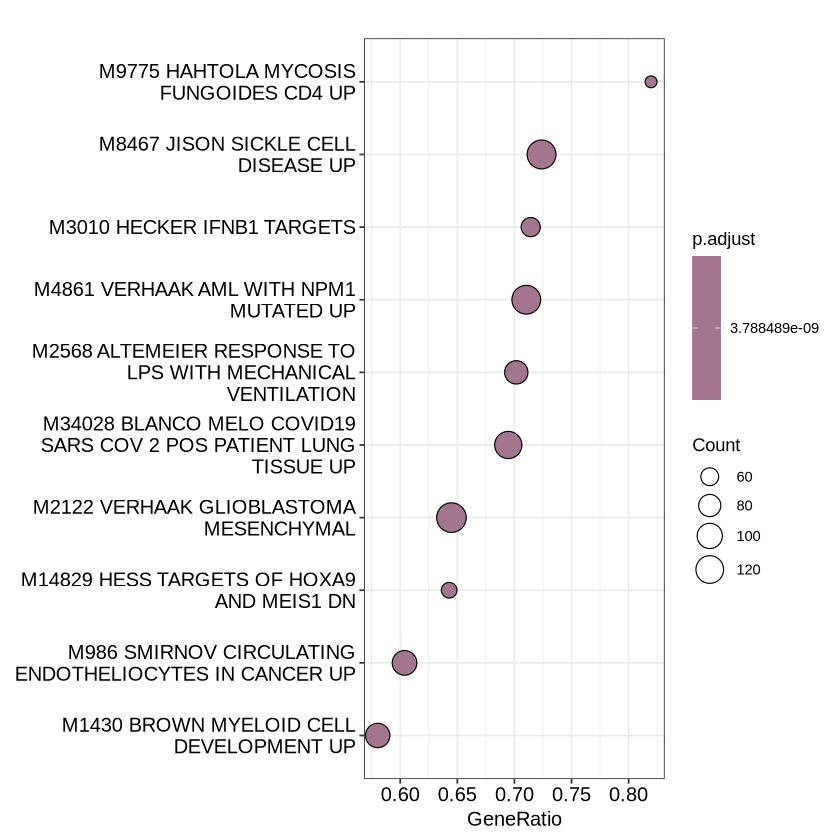

In [125]:
dotplot(res)

Warning message:
“ggrepel: 454 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


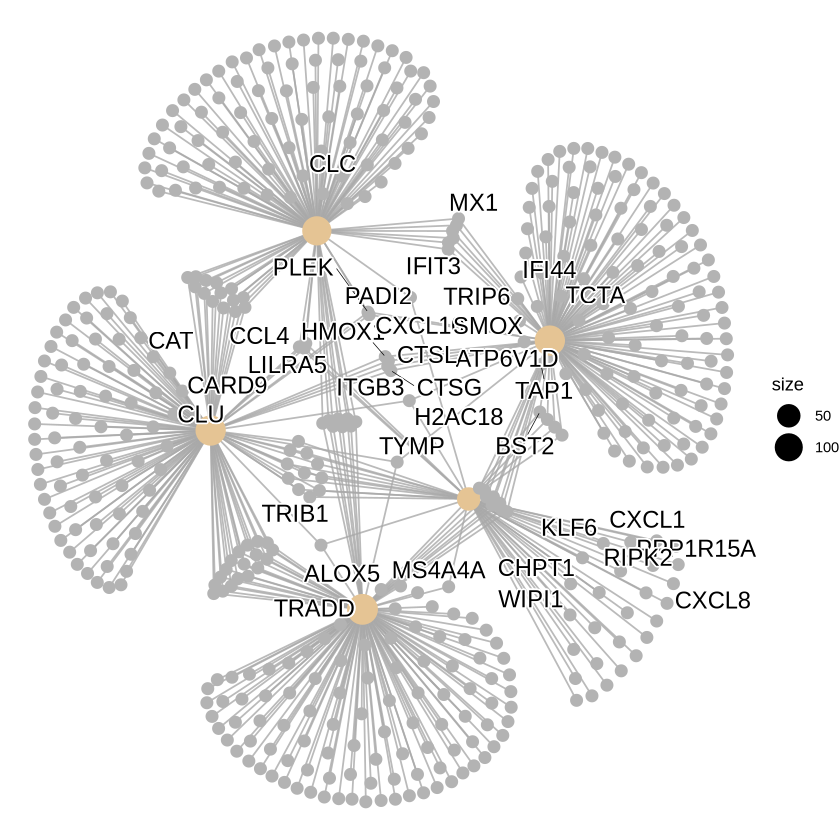

In [129]:
cnetplot(res)

In [147]:
library(DOSE)
library(biomaRt)

de  <- rownames(data.frame(geneList))

# Initialize biomaRt
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

# Convert gene symbols to Entrez IDs
geneConversion <- getBM(filters = "hgnc_symbol",
                        attributes = c("hgnc_symbol", "entrezgene_id"),
                        values = de,
                        mart = ensembl)

# Filter out genes with no Entrez IDRAVmodel

version(RAVmodel)
geneConversion <- geneConversion[!is.na(geneConversion$entrezgene_id), ]

# Create a vector of Entrez IDs for the DE genes
de_entrez <- geneConversion$entrezgene_id

# Run enrichDGN with Entrez IDs
edo <- enrichDGN(de_entrez)


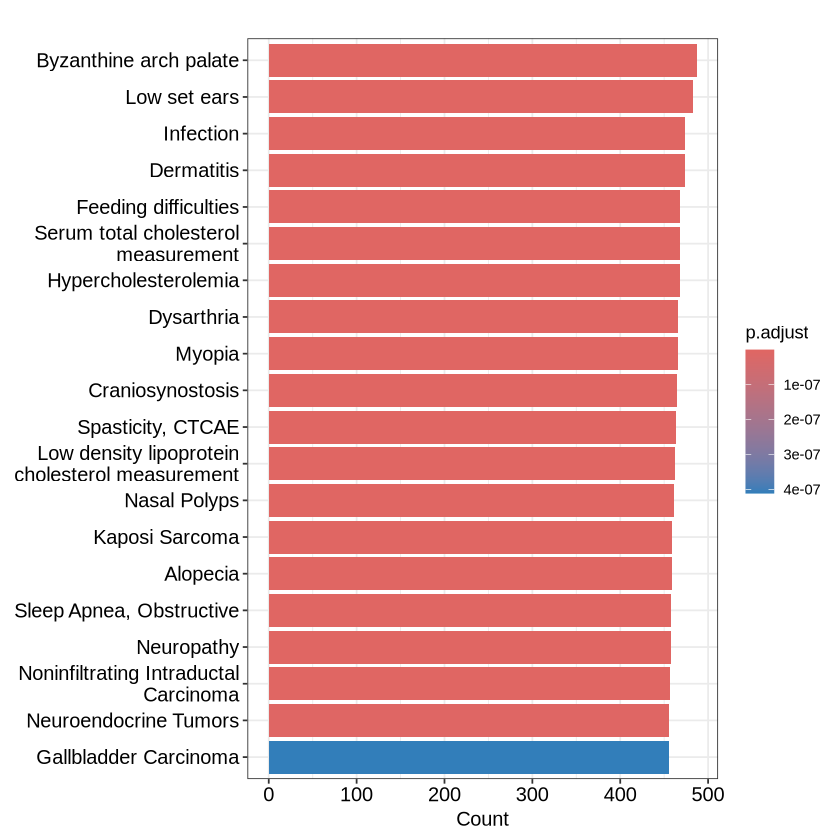

In [152]:
# Convert to data frame to sort by Count
edo_df <- as.data.frame(edo)
edo_df <- edo_df[order(edo_df$Count, decreasing = TRUE),]

# Convert back to enrichResult object
edo_sorted <- edo
edo_sorted@result <- edo_df

# Plot the barplot with the sorted edo object
barplot(edo_sorted, showCategory=20)

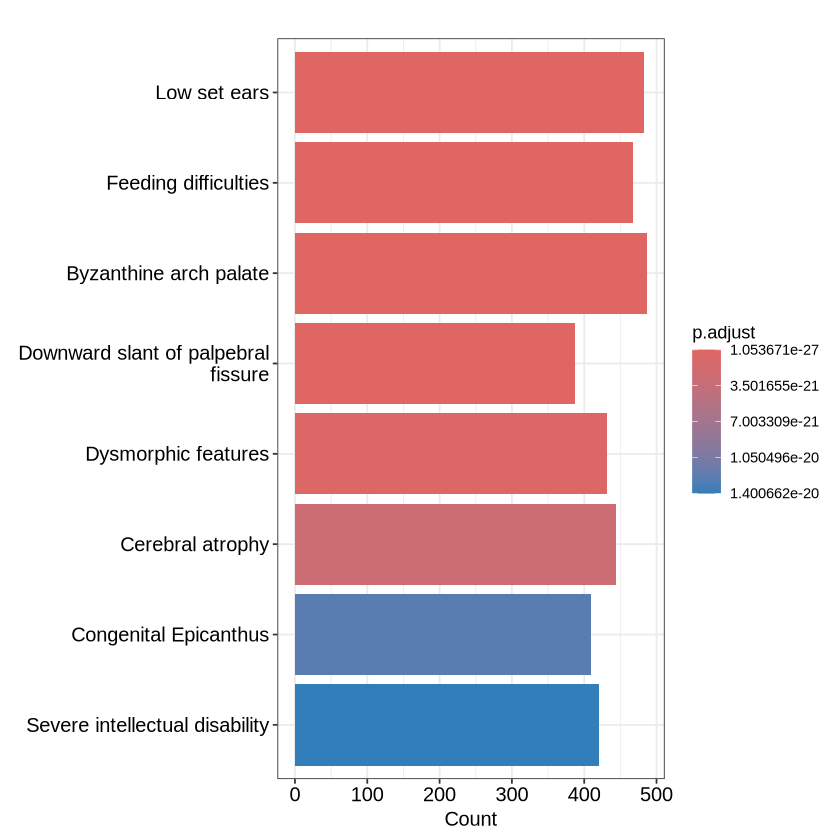

In [153]:
barplot(edo)

In [97]:
trainingDatasets <- "HTP"
note <- "HTP data"
annotGeneSets <- "HTP"   # will be used for the output name
annot_database <- "HTP"   # will be added into the RAVmodel metadata

# Build PCAGenomicSignatures object 
RAVmodel <- PCAGenomicSignatures(assays = list(RAVindex = as.matrix(trainingData_PCclusters$avgLoading)))

ERROR: Error in PCAGenomicSignatures(assays = list(RAVindex = as.matrix(trainingData_PCclusters$avgLoading))): argument "trainingData" is missing, with no default


In [94]:

metadata(RAVmodel) <- trainingData_PCclusters[c("cluster", "size", "k", "n")]
names(metadata(RAVmodel)$size) <- paste0("RAV", seq_len(ncol(RAVmodel)))
geneSets(RAVmodel) <- annot_database
studies(RAVmodel) <- trainingData_PCclusters$studies
silhouetteWidth(RAVmodel) <- trainingData_PCclusters$sw

ERROR: Error in PCAGenomicSignatures(assays = list(RAVindex = as.matrix(trainingData_PCclusters$avgLoading))): argument "trainingData" is missing, with no default


In [91]:
## Input parameters for RAVmodel_536
trainingDatasets <- "HTP"
note <- "HTP data"
annotGeneSets <- "HTP"   # will be used for the output name
annot_database <- "HTP"   # will be added into the RAVmodel metadata

# Build PCAGenomicSignatures object 
RAVmodel <- PCAGenomicSignatures(assays = list(RAVindex = as.matrix(trainingData_PCclusters$avgLoading)))
metadata(RAVmodel) <- trainingData_PCclusters[c("cluster", "size", "k", "n")]
names(metadata(RAVmodel)$size) <- paste0("RAV", seq_len(ncol(RAVmodel)))
geneSets(RAVmodel) <- annot_database
studies(RAVmodel) <- trainingData_PCclusters$studies
silhouetteWidth(RAVmodel) <- trainingData_PCclusters$sw
metadata(RAVmodel)$MeSH_freq <- MeSH_freq
trainingData(RAVmodel)$PCAsummary <- pca_summary[rownames(trainingData(RAVmodel))]
mesh(RAVmodel) <- trainingData_MeSH[rownames(trainingData(RAVmodel))]
updateNote(RAVmodel) <- note
metadata(RAVmodel)$version <- "1.1.0"

ERROR: Error in PCAGenomicSignatures(assays = list(RAVindex = as.matrix(trainingData_PCclusters$avgLoading))): argument "trainingData" is missing, with no default


In [90]:
trainingData_PCclusters$studies

$Cl5_01
[1] "PC1" "PC4"

$Cl5_02
[1] "PC2"  "PC8"  "PC11" "PC13" "PC15" "PC18" "PC19" "PC20"

$Cl5_03
[1] "PC3"  "PC5"  "PC6"  "PC7"  "PC9"  "PC10"

$Cl5_04
[1] "PC12" "PC14"

$Cl5_05
[1] "PC16" "PC17"